In [ ]:
import jax.numpy as jnp
import jax
from jax import random
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import jax.numpy as jnp
from jax import random

def generate_positions_jax(num_positions, x_range, y_range, min_distance, key):

    positions = []

    def distance(p1, p2):
        return jnp.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

    def is_valid_position(new_position):

        return all(distance(new_position, pos) >= min_distance for pos in positions)

    while len(positions) < num_positions:
        key, subkey_x, subkey_y = random.split(key, 3)


        new_x = random.uniform(subkey_x, minval=x_range[0], maxval=x_range[1])
        new_y = random.uniform(subkey_y, minval=y_range[0], maxval=y_range[1])

        new_position = (new_x.item(), new_y.item())  # JAX arrays to Python floats

        if is_valid_position(new_position):
            positions.append(new_position)

    return positions
'''


key = random.PRNGKey(0)
num_positions = 10
x_range = (0, 100)
y_range = (0, 100)
min_distance = 5

positions = generate_positions_jax(num_positions, x_range, y_range, min_distance, key)
print(positions)
'''

'\n\n\nkey = random.PRNGKey(0)\nnum_positions = 10\nx_range = (0, 100)\ny_range = (0, 100)\nmin_distance = 5\n\npositions = generate_positions_jax(num_positions, x_range, y_range, min_distance, key)\nprint(positions)\n'

In [ ]:
def create_triangulation_association_matrix(grid):
        tri = Delaunay(grid)

    num_points = grid.shape[0]
    adj_matrix = jnp.zeros((num_points, num_points))


    for simplex in tri.simplices:
        for i in range(3):
            for j in range(i + 1, 3):
                p1, p2 = simplex[i], simplex[j]
                adj_matrix = adj_matrix.at[p1, p2].set(1)
                adj_matrix = adj_matrix.at[p2, p1].set(1)

    return adj_matrix

In [ ]:
def display_grid_with_bonds(grid, adj_matrix):

    x, y = grid[:, 0], grid[:, 1]

    plt.scatter(x, y, c='blue', marker='o', zorder=5)
    num_points = grid.shape[0]
    for i in range(num_points):
        for j in range(i + 1, num_points):
            if adj_matrix[i, j] == 1:
                plt.plot([grid[i, 0], grid[j, 0]], [grid[i, 1], grid[j, 1]], 'k-', zorder=1)


    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Grid of Points with Bonds')


    plt.grid(True)


    plt.show()

In [ ]:
import jax
import jax.numpy as jnp

def remove_random_bonds(adj_matrix, num_bonds=20, seed=0):

    assert (adj_matrix == adj_matrix.T).all(), "Adjacency matrix must be symmetric"

    key = jax.random.PRNGKey(seed)

    non_zero_indices = jnp.array(jnp.triu(adj_matrix).nonzero()).T

    chosen_indices = jax.random.choice(key, len(non_zero_indices), (min(num_bonds, len(non_zero_indices)),), replace=False)
    indices_to_remove = non_zero_indices[chosen_indices]

    for (i, j) in indices_to_remove:
        #print(f"Removing bond between node {i} and node {j}")
        adj_matrix = adj_matrix.at[i, j].set(0)
        adj_matrix = adj_matrix.at[j, i].set(0)

    return adj_matrix



In [ ]:
def spring_force(pos1, pos2, rest_length, k=1.0):
    displacement = pos2 - pos1
    distance = jnp.linalg.norm(displacement)
    direction = displacement / (distance + 1e-8)
    force_magnitude = -k * (distance - rest_length)
    return force_magnitude * direction

def angular_spring_force(p1, p2, p3, rest_angle, k=1.0):
    v1 = p1 - p2
    v2 = p3 - p2
    angle = jnp.arctan2(jnp.linalg.norm(jnp.cross(v1, v2)), jnp.dot(v1, v2))
    angle_difference = angle - rest_angle
    return -k * angle_difference

In [ ]:
import jax.numpy as jnp

def calculate_initial_lengths_and_angles(grid, adj_matrix):
    num_points = grid.shape[0]
    rest_lengths = jnp.zeros_like(adj_matrix, dtype=float)
    rest_angles = {}


    for i in range(num_points):
        for j in range(i + 1, num_points):
            if adj_matrix[i, j] == 1:
                dist = jnp.linalg.norm(grid[i] - grid[j])
                rest_lengths = rest_lengths.at[i, j].set(dist)
                rest_lengths = rest_lengths.at[j, i].set(dist)  # Symmetric

    for i in range(num_points):
        neighbors = jnp.where(adj_matrix[i] == 1)[0]
        for j in range(len(neighbors)):
            for k in range(j + 1, len(neighbors)):
                neighbor1 = int(neighbors[j])  # Convert to Python int
                neighbor2 = int(neighbors[k])  # Convert to Python int
                v1 = grid[neighbor1] - grid[i]
                v2 = grid[neighbor2] - grid[i]
                angle = jnp.arccos(jnp.dot(v1, v2) / (jnp.linalg.norm(v1) * jnp.linalg.norm(v2)))
                rest_angles[(i, neighbor1, neighbor2)] = angle

    return rest_lengths, rest_angles

def update_positions(grid, adj_matrix, fixed_indices, dt=0.01, num_iterations=100, k_spring=1.0, k_angle=0.1):

    grid = grid.copy()
    num_points = grid.shape[0]


    rest_lengths, rest_angles = calculate_initial_lengths_and_angles(grid, adj_matrix)


    for _ in range(num_iterations):
        forces = jnp.zeros_like(grid)


        for i in range(num_points):
            for j in range(i + 1, num_points):
                if adj_matrix[i, j] == 1:

                    rest_length = rest_lengths[i, j]
                    force = spring_force(grid[i], grid[j], rest_length, k_spring)
                    forces = forces.at[i].add(force)
                    forces = forces.at[j].add(-force)


        for i in range(num_points):
            neighbors = jnp.where(adj_matrix[i] == 1)[0]
            for j in range(len(neighbors)):
                for k in range(j + 1, len(neighbors)):
                    neighbor1 = int(neighbors[j])  # Convert to Python int
                    neighbor2 = int(neighbors[k])  # Convert to Python int

                    rest_angle = rest_angles[(i, neighbor1, neighbor2)]
                    angle_force = angular_spring_force(grid[neighbor1], grid[i], grid[neighbor2], rest_angle, k_angle)
                    forces = forces.at[i].add(angle_force)


        forces = forces.at[fixed_indices].set(0.0)  # No movement for fixed points
        grid = grid + dt * forces

    return grid


In [ ]:
import jax.numpy as jnp

def update_positions_v3(grid, adj_matrix, fixed_indices, pulling_indices, dt=0.01, num_iterations=100, k_spring=1e9, k_angle=0.1, pulling_force=(-1.0, 0.0)):

    grid = grid.copy()
    num_points = grid.shape[0]


    rest_lengths, rest_angles = calculate_initial_lengths_and_angles(grid, adj_matrix)

    for _ in range(num_iterations):
        forces = jnp.zeros_like(grid)
        for index in pulling_indices:
            forces = forces.at[index].add(jnp.array(pulling_force))

        fixed_indices_rows = [index for index in fixed_indices]
        forces = forces.at[fixed_indices].set(0.0)

        for i in range(num_points):
            for j in range(i + 1, num_points):
                if adj_matrix[i, j] == 1:
                    rest_length = rest_lengths[i, j]
                    force = spring_force(grid[i], grid[j], rest_length, k_spring)
                    forces = forces.at[i].add(force)
                    forces = forces.at[j].add(-force)

        for i in range(num_points):
            neighbors = jnp.where(adj_matrix[i] == 1)[0]
            for j in range(len(neighbors)):
                    for k in range(j + 1, len(neighbors)):
                        neighbor1 = neighbors[j]
                        neighbor2 = neighbors[k]
                        rest_angle = rest_angles[tuple(np.array((i, neighbor1, neighbor2)))]
                        angle_force = angular_spring_force(grid[neighbor1], grid[i], grid[neighbor2], rest_angle, k_angle)
                        forces = forces.at[i].add(angle_force)



        grid = grid + dt * forces

    return grid


In [ ]:
def difference_of_y_components_at_indices(array, index1, index2):
      y_component1 = array[index1, 1]  # Assuming y-component is at index 1
    y_component2 = array[index2, 1]  # Assuming y-component is at index 1
    return y_component1 - y_component2

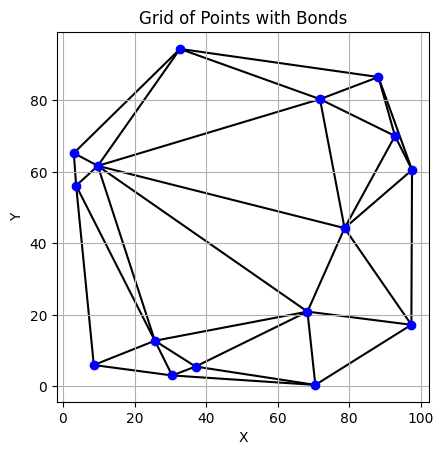

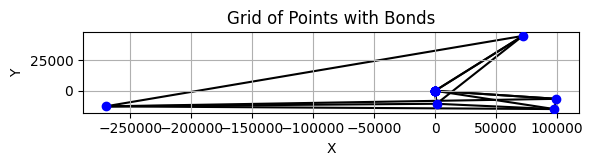

In [ ]:
n = 4
grid = generate_positions_jax(n*n, (0, 100), (0, 100), 5, random.PRNGKey(0))
grid = jnp.array(grid)
adj_matrix = create_triangulation_association_matrix(grid)
display_grid_with_bonds(grid, adj_matrix)
disturbed_grid = update_positions_v3(grid, adj_matrix, fixed_indices=np.array([0]),pulling_indices=np.array([-1]), num_iterations=2)
display_grid_with_bonds(disturbed_grid, adj_matrix)

98.0


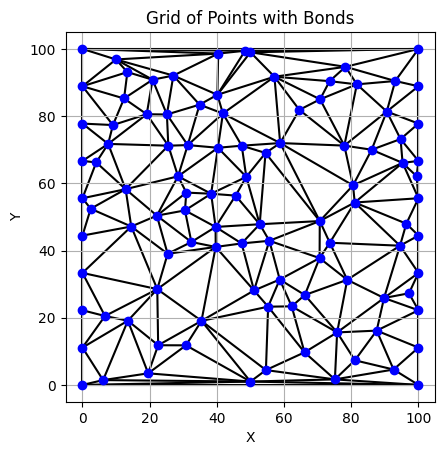

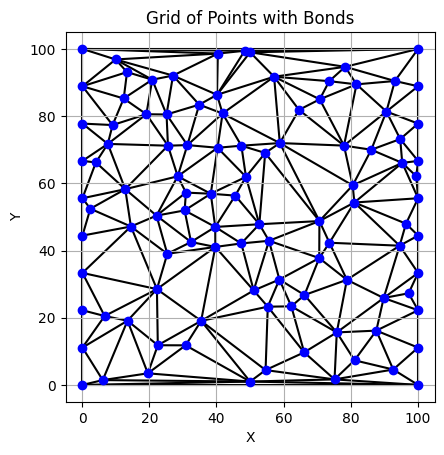

98.0


In [ ]:
#Main
n = 9
num_points = 10  # Number of points in each column
x_fixed_even = 0  # x-coordinate for evenly spaced points
y_min, y_max = 0, 100  # Range for y-coordinates
even_y_values = np.linspace(y_min, y_max, num_points)
pull = [(x_fixed_even, y) for y in even_y_values]
hold = [(100, y) for y in even_y_values]
hold = jnp.array(hold)
pull = jnp.array(pull)
measure_point_concave = 0.01
measure_point = [(50,y_max-y_max*measure_point_concave),(50,y_min+y_max*measure_point_concave)]
measure_point = jnp.array(measure_point)


grid = generate_positions_jax(n * n, (0, 100), (0, 100), 5, random.PRNGKey(1))
grid = jnp.array(grid)
grid = jnp.concatenate((hold, pull,measure_point,grid))

print(difference_of_y_components_at_indices(grid,20,21))

adj_matrix = create_triangulation_association_matrix(grid)
display_grid_with_bonds(grid, adj_matrix)
fix_indice = grid[0]
distrurbedgrid = update_positions_v3(grid,adj_matrix,jnp.array((0,1,2,3,4,5,6,7,8,9)),jnp.array((10,11,12,13,14,15,16,17,18,19)),dt=0.1, num_iterations=1, k_spring=0.1, k_angle=0.1, pulling_force=(1.0, 0.0))
display_grid_with_bonds(distrurbedgrid, adj_matrix)
print(difference_of_y_components_at_indices(distrurbedgrid,20,21))

In [ ]:
print(distrurbedgrid)

[[ 1.00000000e+02 -3.70666409e-09]
 [ 1.00000000e+02  1.11111069e+01]
 [ 1.00000000e+02  2.22222176e+01]
 [ 1.00000000e+02  3.33333282e+01]
 [ 1.00000000e+02  4.44444389e+01]
 [ 1.00000000e+02  5.55555534e+01]
 [ 1.00000000e+02  6.66666641e+01]
 [ 1.00000000e+02  7.77777786e+01]
 [ 1.00000000e+02  8.88888855e+01]
 [ 1.00000000e+02  1.00000000e+02]
 [ 1.00000016e-01  1.12690035e-08]
 [ 9.99965519e-02  1.11111069e+01]
 [ 9.99965519e-02  2.22222176e+01]
 [ 9.99965519e-02  3.33333282e+01]
 [ 9.99965444e-02  4.44444389e+01]
 [ 9.99965519e-02  5.55555534e+01]
 [ 9.99965519e-02  6.66666641e+01]
 [ 9.99965519e-02  7.77777786e+01]
 [ 9.99965519e-02  8.88888855e+01]
 [ 9.99999568e-02  1.00000000e+02]
 [ 5.00000000e+01  9.90000000e+01]
 [ 5.00000000e+01  1.00000012e+00]
 [ 4.01535378e+01  8.63500977e+01]
 [ 3.96244888e+01  4.70171814e+01]
 [ 6.70863390e+00  2.05087891e+01]
 [ 1.23860474e+01  8.52478714e+01]
 [ 3.08141937e+01  1.17852926e+01]
 [ 2.51306648e+01  8.04870377e+01]
 [ 1.33713608e+01  9

In [ ]:
#Main
n = 4
num_points = 10  # Number of points in each column
x_fixed_even = 0  # x-coordinate for evenly spaced points
y_min, y_max = 0, 100  # Range for y-coordinates
even_y_values = np.linspace(y_min, y_max, num_points)
pull = [(x_fixed_even, y) for y in even_y_values]
hold = [(100, y) for y in even_y_values]
hold = jnp.array(hold)
pull = jnp.array(pull)
measure_point_concave = 0.01
measure_point = [(50,y_max-y_max*measure_point_concave),(50,y_min+y_max*measure_point_concave)]
measure_point = jnp.array(measure_point)


grid = generate_positions_jax(n * n, (0, 100), (0, 100), 5, random.PRNGKey(2))
grid = jnp.array(grid)
grid = jnp.concatenate((hold, pull,measure_point,grid))
adj_matrix = create_triangulation_association_matrix(grid)
for i in range(10):
  print("gen",i)
  print("diff before disturb:", difference_of_y_components_at_indices(grid,20,21))
  display_grid_with_bonds(grid, adj_matrix)
  fix_indice = grid[0]
  distrurbedgrid = update_positions_v3(grid,adj_matrix,jnp.array((0,1,2,3,4,5,6,7,8,9)),jnp.array((10,11,12,13,14,15,16,17,18,19)),dt=0.1, num_iterations=50, k_spring=0.1, k_angle=0.1, pulling_force=(-1.0, 0.0))

  print("diff after disturb:", difference_of_y_components_at_indices(distrurbedgrid,20,21))
  display_grid_with_bonds(distrurbedgrid, adj_matrix)

  adj_matrix = remove_random_bonds(adj_matrix,3)

In [ ]:
import jax.numpy as jnp
import numpy as np

def spring_force_vectorized(points_i, points_j, rest_lengths, k_spring):

    displacement = points_j - points_i

    distances = jnp.linalg.norm(displacement, axis=1)

    epsilon = 1e-9
    distances = jnp.where(distances > 0, distances, epsilon)

    force_magnitudes = k_spring * (distances - rest_lengths) / distances

    force_vectors = displacement * force_magnitudes[:, None]

    return force_vectors
def update_positions_v3_optimized(grid, adj_matrix, fixed_indices, pulling_indices, dt=0.01, max_iterations=100, tol=1e-5, k_spring=1e9, k_angle=0.1, pulling_force=(-1.0, 0.0)):
    grid = grid.copy()
    num_points = grid.shape[0]

    rest_lengths, rest_angles = calculate_initial_lengths_and_angles(grid, adj_matrix)

    prev_grid = grid.copy()
    converged = False

    for iteration in range(max_iterations):
        forces = jnp.zeros_like(grid)

        pulling_forces = jnp.array(pulling_force)
        forces = forces.at[pulling_indices].add(pulling_forces)

        forces = forces.at[fixed_indices].set(0.0)

        i, j = jnp.where(adj_matrix == 1)
        rest_lengths_vec = rest_lengths[i, j]
        force_vectors = spring_force_vectorized(grid[i], grid[j], rest_lengths_vec, k_spring)
        forces = forces.at[i].add(force_vectors)
        forces = forces.at[j].add(-force_vectors)

        for i in range(num_points):
          neighbors = jnp.where(adj_matrix[i] == 1)[0]
          if len(neighbors) < 2:
            continue
          pairs = [(neighbors[j], neighbors[k]) for j in range(len(neighbors)) for k in range(j + 1, len(neighbors))]
          for neighbor1, neighbor2 in pairs:
            rest_angle_key = tuple(np.array((i, neighbor1, neighbor2)))
            rest_angle = rest_angles.get(rest_angle_key, 0)
            angle_force = angular_spring_force(grid[neighbor1], grid[i], grid[neighbor2], rest_angle, k_angle)
            forces = forces.at[i].add(angle_force)


        grid = grid + dt * forces
        avg_displacement = jnp.mean(jnp.linalg.norm(grid - prev_grid, axis=1))
        if avg_displacement < tol:
            converged = True
            break
        prev_grid = grid.copy()

    if not converged:
        print("Warning: reached max iterations .")

    return grid


In [ ]:
import numpy as np

def calculate_poisson_ratio(initial_grid, deformed_grid, axis=0):

    initial_length_axial = np.max(initial_grid[:, axis]) - np.min(initial_grid[:, axis])
    deformed_length_axial = np.max(deformed_grid[:, axis]) - np.min(deformed_grid[:, axis])
    axial_strain = (deformed_length_axial - initial_length_axial) / initial_length_axial
    transverse_axis = 1 - axis  # if axis=0 (x-axis), transverse_axis=1 (y-axis) and vice versa
    initial_length_transverse = np.max(initial_grid[:, transverse_axis]) - np.min(initial_grid[:, transverse_axis])
    deformed_length_transverse = np.max(deformed_grid[:, transverse_axis]) - np.min(deformed_grid[:, transverse_axis])

    transverse_strain = (deformed_length_transverse - initial_length_transverse) / initial_length_transverse

    poisson_ratio = -transverse_strain / axial_strain

    return poisson_ratio

initial_grid = np.array([[0, 0], [1, 0], [0, 1], [1, 1]])
deformed_grid = np.array([[0, 0], [1.1, 0], [0, 1.05], [1.1, 1.05]])

#poisson_ratio = calculate_poisson_ratio(initial_grid, deformed_grid, axis=0)


gen 0
diff before disturb: 98.0


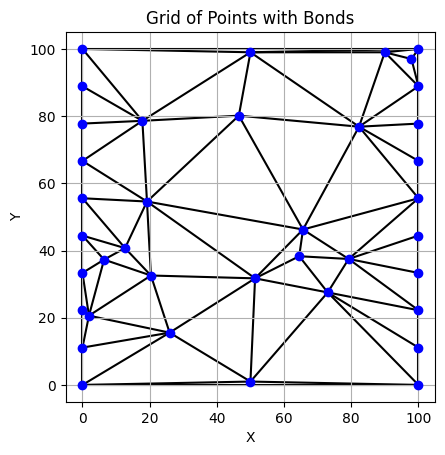

diff after disturb: 97.63909


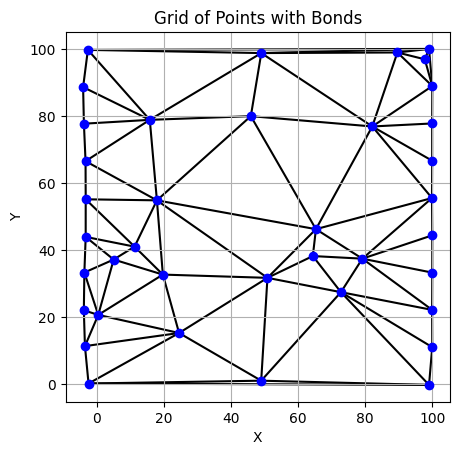

gen 1
diff before disturb: 98.0


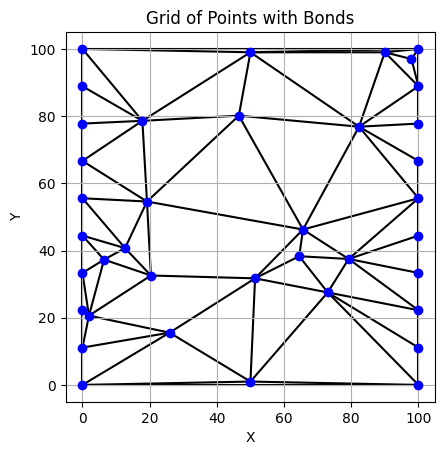

diff after disturb: 97.67947


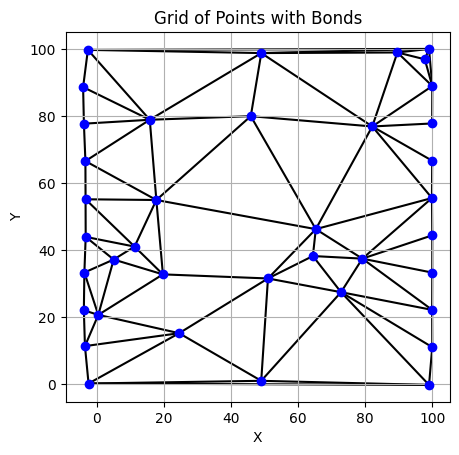

gen 2
diff before disturb: 98.0


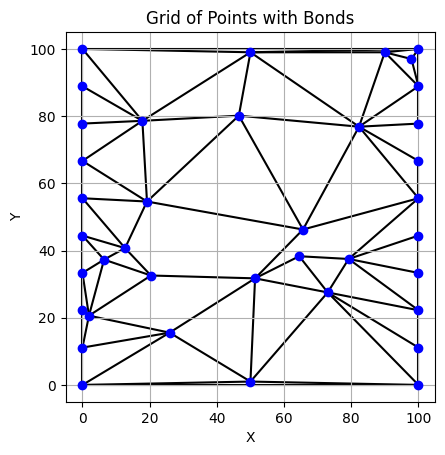

diff after disturb: 97.68214


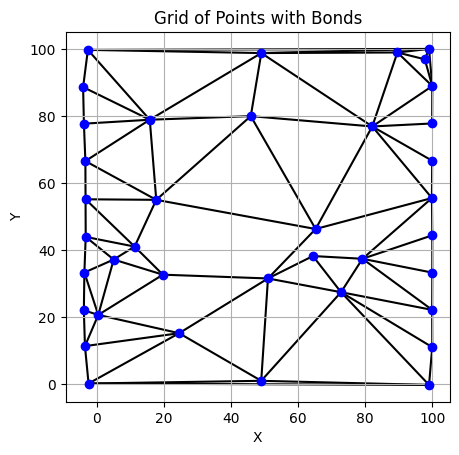

gen 3
diff before disturb: 98.0


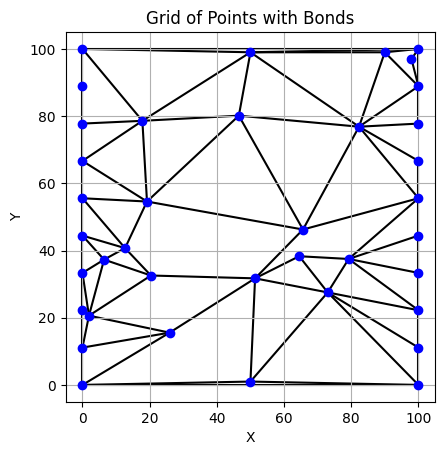

diff after disturb: 97.733025


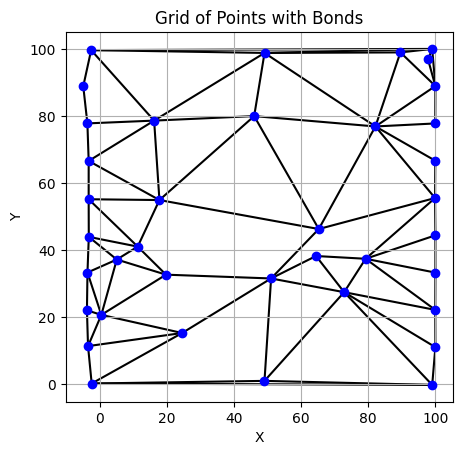

gen 4
diff before disturb: 98.0


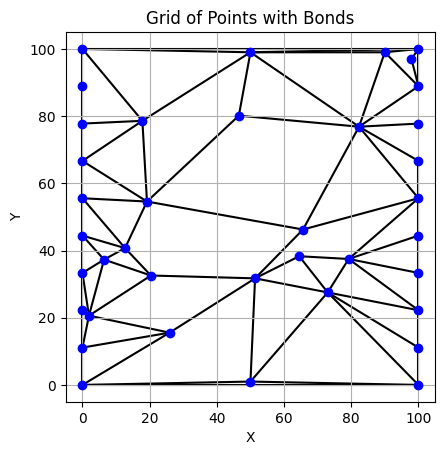

diff after disturb: 97.706406


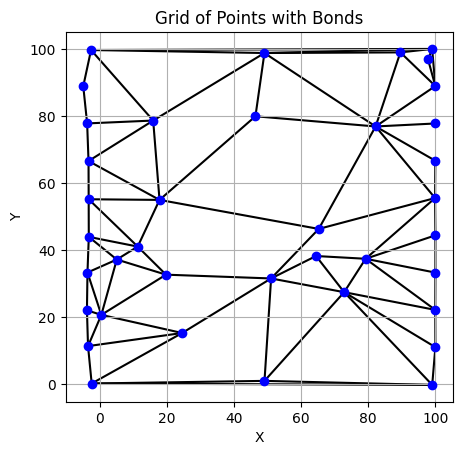

gen 5
diff before disturb: 98.0


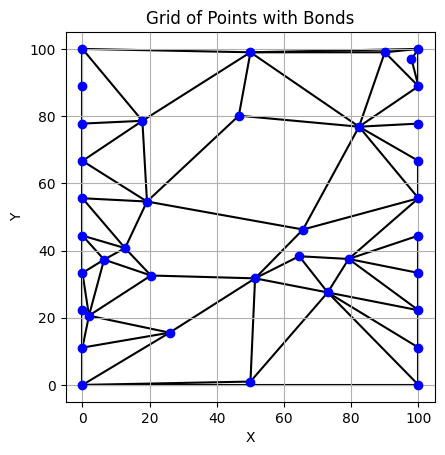

diff after disturb: 97.71693


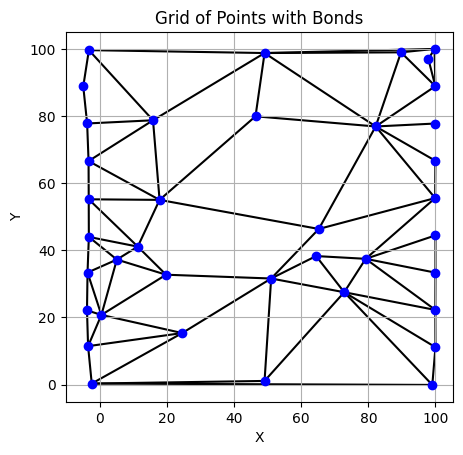

gen 6
diff before disturb: 98.0


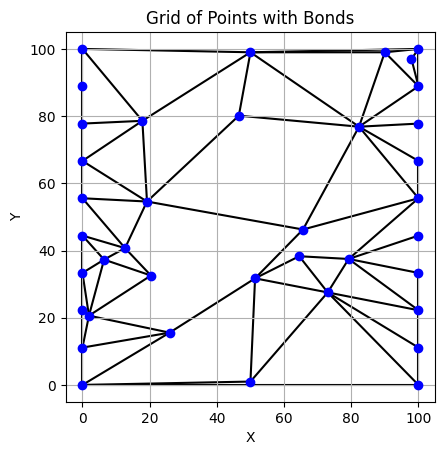

diff after disturb: 97.71933


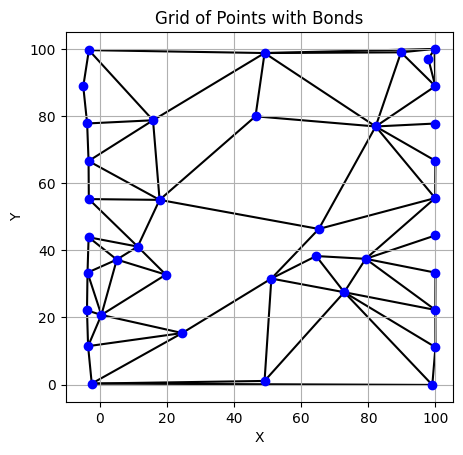

gen 7
diff before disturb: 98.0


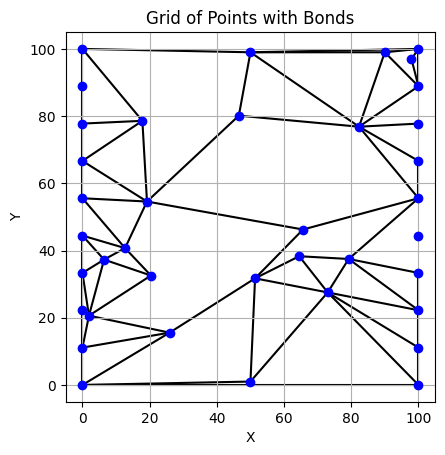

diff after disturb: 97.869125


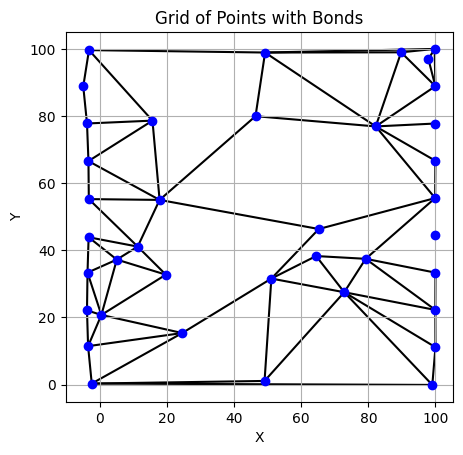

gen 8
diff before disturb: 98.0


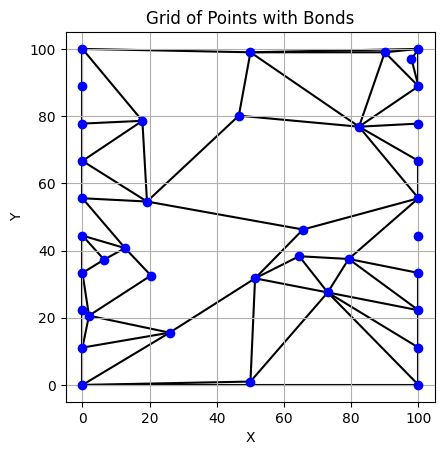

diff after disturb: 97.86693


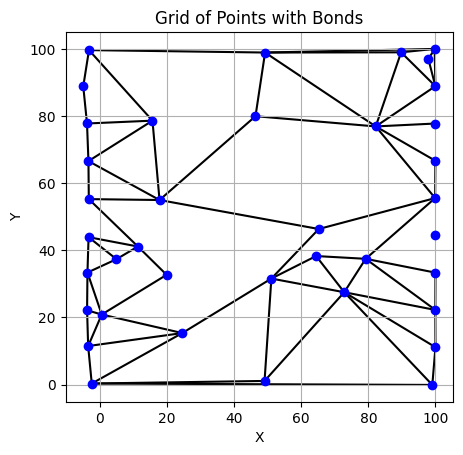

gen 9
diff before disturb: 98.0


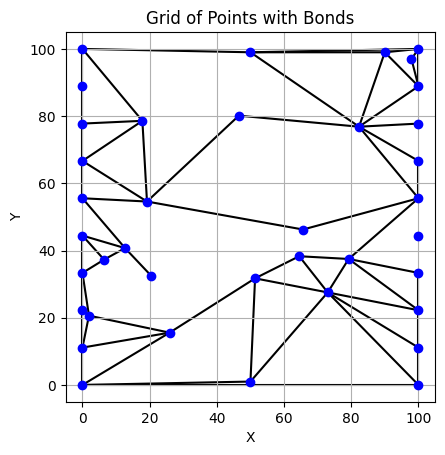

diff after disturb: 97.849144


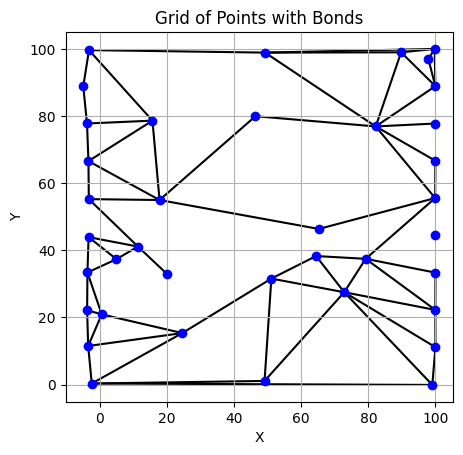

In [ ]:
#Main
n = 4
num_points = 10  # Number of points in each column
x_fixed_even = 0  # x-coordinate for evenly spaced points
y_min, y_max = 0, 100  # rnge for y-coordinates
even_y_values = np.linspace(y_min, y_max, num_points)
pull = [(x_fixed_even, y) for y in even_y_values]
hold = [(100, y) for y in even_y_values]
hold = jnp.array(hold)
pull = jnp.array(pull)
measure_point_concave = 0.01
measure_point = [(50,y_max-y_max*measure_point_concave),(50,y_min+y_max*measure_point_concave)]
measure_point = jnp.array(measure_point)


grid = generate_positions_jax(n * n, (0, 100), (0, 100), 5, random.PRNGKey(2))
grid = jnp.array(grid)
grid = jnp.concatenate((hold, pull,measure_point,grid))
adj_matrix = create_triangulation_association_matrix(grid)
for i in range(10):
  print("gen",i)
  print("diff before disturb:", difference_of_y_components_at_indices(grid,20,21))
  display_grid_with_bonds(grid, adj_matrix)
  fix_indice = grid[0]
  distrurbedgrid = update_positions_v3_optimized(grid,adj_matrix,jnp.array((0,1,2,3,4,5,6,7,8,9)),jnp.array((10,11,12,13,14,15,16,17,18,19)),dt=0.1, max_iterations=50, k_spring=0.1, k_angle=0.1, pulling_force=(-1.0, 0.0))

  print("diff after disturb:", difference_of_y_components_at_indices(distrurbedgrid,20,21))
  display_grid_with_bonds(distrurbedgrid, adj_matrix)

  adj_matrix = remove_random_bonds(adj_matrix,3)

gen 0


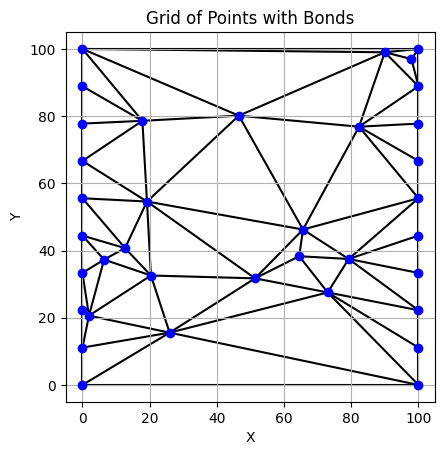

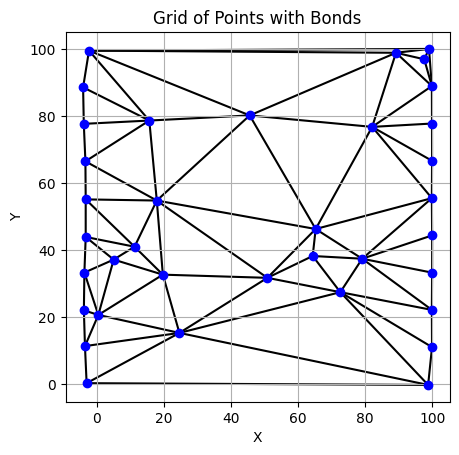

poisson ratio: -0.044329762
gen 1


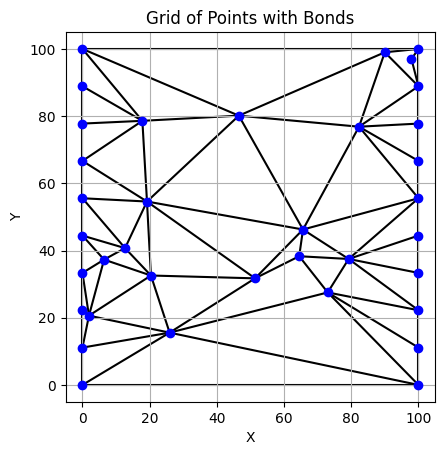

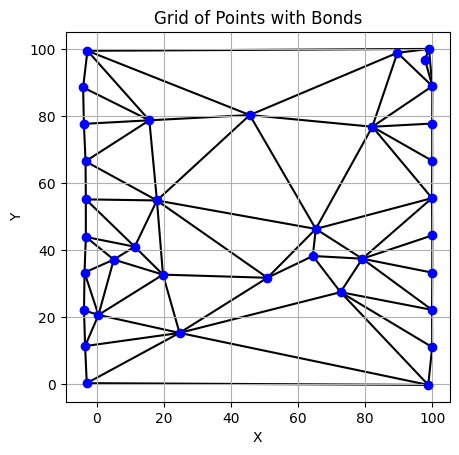

poisson ratio: -0.043108936


In [ ]:
#Main
n = 4
num_points = 10  # Number of points in each column
x_fixed_even = 0  # x-coordinate for evenly spaced points
y_min, y_max = 0, 100  # rnge for y-coordinates
even_y_values = np.linspace(y_min, y_max, num_points)
pull = [(x_fixed_even, y) for y in even_y_values]
hold = [(100, y) for y in even_y_values]
hold = jnp.array(hold)
pull = jnp.array(pull)


grid = generate_positions_jax(n * n, (0, 100), (0, 100), 5, random.PRNGKey(2))
grid = jnp.array(grid)
grid = jnp.concatenate((hold, pull,grid))
adj_matrix = create_triangulation_association_matrix(grid)
for i in range(2):
  print("gen",i)

  display_grid_with_bonds(grid, adj_matrix)
  fix_indice = grid[0]
  distrurbedgrid = update_positions_v3_optimized(grid,adj_matrix,jnp.array((0,1,2,3,4,5,6,7,8,9)),jnp.array((10,11,12,13,14,15,16,17,18,19)),dt=0.1, max_iterations=50, k_spring=0.1, k_angle=0.1, pulling_force=(-1.0, 0.0))


  display_grid_with_bonds(distrurbedgrid, adj_matrix)
  poisson_ratio = calculate_poisson_ratio(grid, distrurbedgrid, axis=0)
  print("poisson ratio:", poisson_ratio)
  adj_matrix = remove_random_bonds(adj_matrix,3)